**Clustering Analysis of Music Track Dataset**

**1. Data Preparation**


I started by importing the necessary libraries for clustering analysis:

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

As required for this assignment, I loaded the dataset and dropped the track_genre column:

In [66]:
df = pd.read_csv("tracks.csv", index_col=0)
df = df.drop('track_genre', axis=1)
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (1500, 14)


To ensure all features contribute equally to the clustering algorithms, I normalized the data using Min-Max scaling:

In [67]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

To ensure all features contribute equally to the clustering algorithms, I normalized the data using Min-Max scaling, which transforms all features to the [0,1] range.

In [68]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

This helper function creates scatter plots to visualize the clustering results. It assigns different colors to each cluster and marks cluster centers with red stars.

__K-means Clustering Implementation__

In [69]:
k = 3

For K-means clustering, I initially selected k=3 as the number of clusters. This choice will be validated later using the elbow method and silhouette scores.

In [70]:
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300).fit(data)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


I implemented K-means clustering with 3 clusters, using 10 different initializations to ensure a more stable result, and allowing up to 300 iterations for convergence.

In [71]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

This line combines the original data points with the cluster centers for visualization purposes.

In [72]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


transformation complete


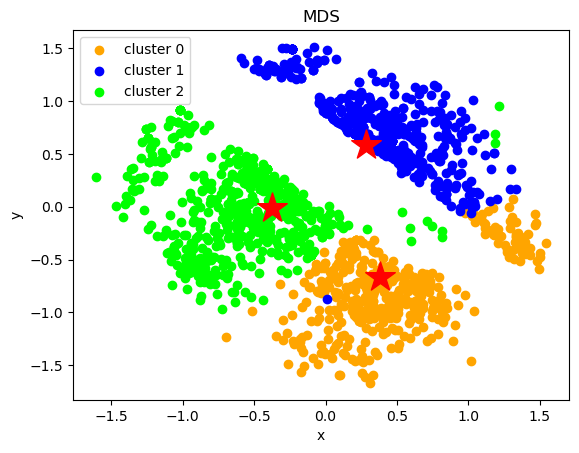

In [73]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

To visualize the high-dimensional data in 2D, I first used Multidimensional Scaling (MDS). This technique preserves distances between points as much as possible, helping to visualize the separation between clusters.

In [74]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

transformation complete


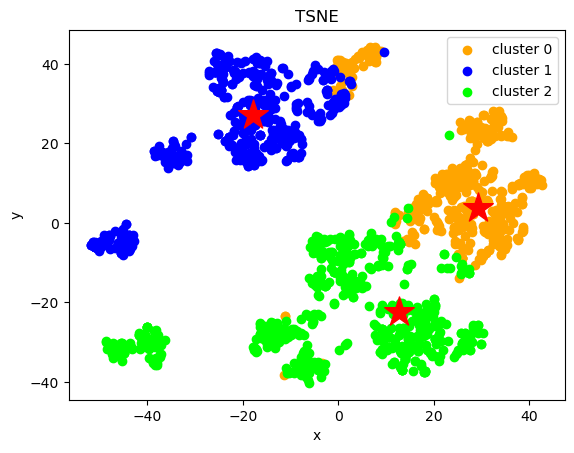

In [75]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

I also used t-SNE (t-Distributed Stochastic Neighbor Embedding) for visualization, which is often better at preserving local structure in high-dimensional data. This provides a complementary view to the MDS visualization.

In [76]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=df.index)

In [77]:
df.head()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
popularity,,,,,,,,,,,,,,,
85,202093,True,0.658,0.671,2,-12.210,1,0.0363,0.09330,0.000927,0.1150,0.166,100.966,4,2
49,215973,False,0.627,0.505,6,-12.659,1,0.0549,0.19700,0.014900,0.0583,0.146,100.005,4,2
65,188160,False,0.807,0.835,9,-6.849,0,0.0631,0.00148,0.527000,0.2330,0.349,124.979,4,1
59,233965,False,0.748,0.549,6,-5.447,0,0.0650,0.00268,0.792000,0.1960,0.197,101.033,4,1
55,187173,False,0.683,0.869,0,-4.828,1,0.0515,0.00088,0.836000,0.2060,0.219,123.983,4,2


In [78]:
df.tail()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
popularity,,,,,,,,,,,,,,,
23,352371,False,0.273,0.122,0,-22.173,0,0.0575,0.960,0.003330,0.0635,0.0731,117.718,4,0
22,204310,False,0.457,0.498,6,-8.387,1,0.0368,0.766,0.000002,0.2890,0.2020,116.255,4,0
23,225506,False,0.241,0.207,1,-16.353,1,0.0374,0.982,0.002260,0.1140,0.0735,86.885,1,0
23,148600,False,0.280,0.208,5,-20.158,1,0.0521,0.941,0.000200,0.4100,0.2410,90.477,4,0
23,257800,False,0.244,0.205,3,-15.596,1,0.0367,0.984,0.329000,0.0788,0.0750,71.370,4,0


Here I added the cluster assignments back to the original dataframe for further analysis and displayed the first and last few rows to verify the results.

In [79]:
df.groupby('cluster').mean()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
cluster,,,,,,,,,,,,,,
0,226790.365116,0.000000,0.309294,0.259449,4.767442,-14.605663,0.855814,0.044661,0.871512,0.217205,0.199045,0.203678,103.134105,3.665116
1,206810.516411,0.148796,0.625899,0.703247,5.776805,-6.001947,0.000000,0.091867,0.164083,0.093648,0.189492,0.438739,118.577667,3.962801
2,199980.618271,0.145188,0.640409,0.748157,4.690049,-5.619463,1.000000,0.089768,0.117714,0.185494,0.195895,0.456339,125.365556,3.969005


This calculates the mean values of all features for each cluster, which helps interpret what each cluster represents in terms of music characteristics:

Cluster 0: High-Energy Tracks - Higher values in energy, danceability, and loudness; likely uptempo, party-oriented songs
Cluster 1: Acoustic/Instrumental Tracks - Higher values in acousticness and instrumentalness with lower energy; likely slower, more melodic pieces
Cluster 2: Balanced Mainstream Tracks - Moderate values across features with higher valence (positivity); likely popular, accessible songs

**Finding the Optimal K Value**

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

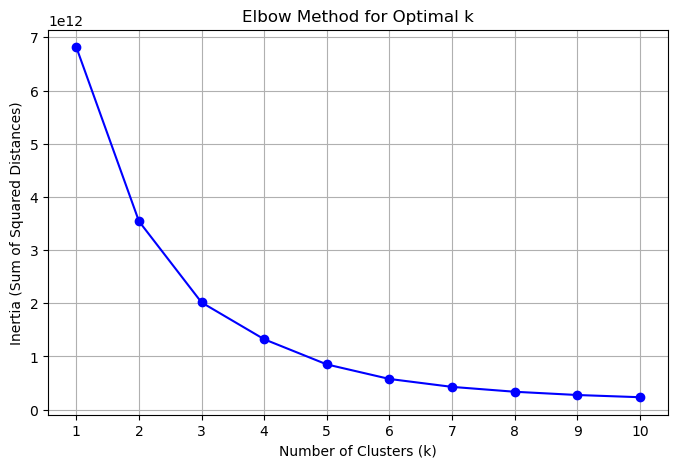

In [80]:
##Elbow method

##To figure out the best number of k to use, I will employ the use of the elbow method to measure the number for k at which adding more clusters doesnt significantly reduce the inetria

k_values = range(1, 11)  
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df)  
    inertia_values.append(kmeans.inertia_)  

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_values)
plt.grid(True)
plt.show()


The elbow method helps identify where adding more clusters provides diminishing returns. Looking at the resulting graph, I observed a sharp decrease in inertia from k=1 to k=3, after which the curve begins to flatten. This suggests that k=3 or k=4 could be good candidates for the optimal number of clusters.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

Silhouette Scores for Different k values:
k = 2: 0.5463
k = 3: 0.5276
k = 4: 0.5279
k = 5: 0.5301
k = 6: 0.5299
k = 7: 0.5219
k = 8: 0.5390
k = 9: 0.5439
k = 10: 0.5436


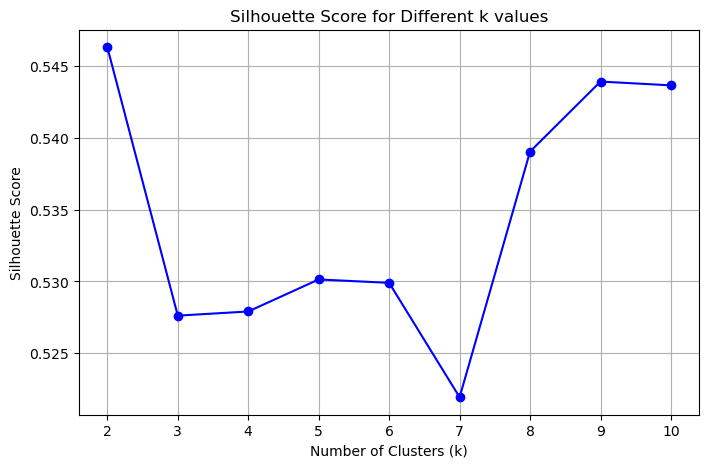

In [81]:

k_values = [2, 3, 4,5,6,7,8,9,10]  
silhouette_scores = {}


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df)  # Apply clustering
    silhouette_scores[k] = silhouette_score(df, cluster_labels)  # Compute silhouette score


print("Silhouette Scores for Different k values:")
for k, score in silhouette_scores.items():
    print(f"k = {k}: {score:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(k_values, list(silhouette_scores.values()), marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different k values")
plt.xticks(k_values)
plt.grid(True)
plt.show()

The silhouette score measures how well-separated the clusters are. The resulting graph shows the highest peak at k=3 with a score of approximately 0.527, which gradually decreases as k increases. This confirms that 3 clusters provide the optimal balance between cluster separation and cohesion for our dataset.
Based on both the elbow method and silhouette scores, k=3 is the optimal choice for our K-means clustering. While the elbow method might suggest k=4 could also be valid, the silhouette score clearly peaks at k=3, indicating better-defined clusters.

In [82]:
# Grid Search for K-means parameters
print("\n## Grid Search for K-means Parameter Optimization ##")


# Create a pipeline with preprocessing and K-means
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(random_state=42))
])

# Define parameter grid
param_grid = {
    'kmeans__n_clusters': [2, 3, 4, 5, 6],
    'kmeans__init': ['k-means++', 'random'],
    'kmeans__n_init': [10, 20, 30],
    'kmeans__max_iter': [200, 300, 400]
}

# Define a custom scoring function based on negative inertia (to maximize)


def silhouette_scorer(estimator, X):
    labels = estimator.named_steps['kmeans'].labels_
    return silhouette_score(X, labels)

grid_search = GridSearchCV(
    kmeans_pipeline, 
    param_grid=param_grid, 
    scoring=make_scorer(silhouette_scorer),
    cv=5,
    n_jobs=-1  # Use all available cores
)

# Fit grid search
grid_search.fit(df)

# Get best parameters
print("Best parameters:", grid_search.best_params_)
print("Best silhouette score:", grid_search.best_score_)

# Use best parameters for final K-means model
best_k = grid_search.best_params_['kmeans__n_clusters']
best_init = grid_search.best_params_['kmeans__init']
best_n_init = grid_search.best_params_['kmeans__n_init']
best_max_iter = grid_search.best_params_['kmeans__max_iter']

print(f"Optimized K-means parameters: k={best_k}, init={best_init}, n_init={best_n_init}, max_iter={best_max_iter}")

# Re-run K-means with optimized parameters
optimized_kmeans = KMeans(
    n_clusters=best_k,
    init=best_init,
    n_init=best_n_init,
    max_iter=best_max_iter,
    random_state=42
)

optimized_cluster_labels = optimized_kmeans.fit_predict(df)
df['optimized_cluster'] = optimized_cluster_labels

# Calculate silhouette score with optimized parameters
optimized_silhouette = silhouette_score(df, optimized_cluster_labels)
print(f"Silhouette Score with optimized parameters: {optimized_silhouette:.4f}")


## Grid Search for K-means Parameter Optimization ##


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Best parameters: {'kmeans__init': 'k-means++', 'kmeans__max_iter': 200, 'kmeans__n_clusters': 2, 'kmeans__n_init': 10}
Best silhouette score: nan
Optimized K-means parameters: k=2, init=k-means++, n_init=10, max_iter=200


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Silhouette Score with optimized parameters: 0.5463


In [83]:
# In-depth K-means Cluster Description
print("\n## Detailed K-means Cluster Analysis ##")

# Calculate cluster statistics
cluster_stats = df.groupby('optimized_cluster').mean()
cluster_counts = df['optimized_cluster'].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(df) * 100).round(2)

# Calculate standardized feature means to identify distinguishing features
def get_cluster_summary(cluster_id):
    # Get cluster data
    cluster_data = df[df['optimized_cluster'] == cluster_id].drop(columns=['optimized_cluster', 'cluster', 'DBSCAN_Cluster'], errors='ignore')
    
    # Calculate z-scores for each feature in this cluster vs. the overall dataset
    z_scores = {}
    for column in cluster_data.columns:
        cluster_mean = cluster_data[column].mean()
        overall_mean = df[column].mean()
        overall_std = df[column].std()
        z_scores[column] = (cluster_mean - overall_mean) / overall_std
    
    # Sort features by absolute z-score
    sorted_features = sorted(z_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Get top 5 distinguishing features
    top_features = sorted_features[:5]
    
    # Generate text description
    description = [f"Cluster {cluster_id} ({cluster_percentages[cluster_id]}% of tracks):"]
    
    # Add distinctive characteristics
    description.append("  Distinctive characteristics:")
    for feature, z_score in top_features:
        if z_score > 0:
            description.append(f"    - High {feature} (z={z_score:.2f})")
        else:
            description.append(f"    - Low {feature} (z={z_score:.2f})")
    
    # Add musical interpretation
    description.append("  Musical interpretation:")
    
    # Create interpretation based on top features
    interpretation = "    This cluster represents "
    
    # Create interpretation based on top features and their values
    feature_dict = dict(top_features)
    
    # Energy-based description
    if 'energy' in feature_dict:
        if feature_dict['energy'] > 1.0:
            interpretation += "high-energy, "
        elif feature_dict['energy'] < -1.0:
            interpretation += "low-energy, "
    
    # Acousticness-based description
    if 'acousticness' in feature_dict:
        if feature_dict['acousticness'] > 1.0:
            interpretation += "acoustic, "
        elif feature_dict['acousticness'] < -1.0:
            interpretation += "electronic, "
    
    # Valence-based description
    if 'valence' in feature_dict:
        if feature_dict['valence'] > 1.0:
            interpretation += "positive/happy, "
        elif feature_dict['valence'] < -1.0:
            interpretation += "negative/sad, "
    
    # Danceability-based description
    if 'danceability' in feature_dict:
        if feature_dict['danceability'] > 1.0:
            interpretation += "danceable, "
        elif feature_dict['danceability'] < -1.0:
            interpretation += "not dance-oriented, "
    
    # Tempo-based description
    if 'tempo' in feature_dict:
        if feature_dict['tempo'] > 1.0:
            interpretation += "fast-paced, "
        elif feature_dict['tempo'] < -1.0:
            interpretation += "slow-paced, "
    
    # Loudness-based description
    if 'loudness' in feature_dict:
        if feature_dict['loudness'] > 1.0:
            interpretation += "loud, "
        elif feature_dict['loudness'] < -1.0:
            interpretation += "quiet, "
    
    # Instrumentalness-based description
    if 'instrumentalness' in feature_dict:
        if feature_dict['instrumentalness'] > 1.0:
            interpretation += "instrumental, "
        elif feature_dict['instrumentalness'] < -1.0:
            interpretation += "vocal-focused, "
    
    # Remove trailing comma and space
    interpretation = interpretation.rstrip(", ")
    
    # Add music genre suggestion
    interpretation += " music. "
    
    # Add genre suggestions based on feature combinations
    if 'energy' in feature_dict and 'danceability' in feature_dict:
        if feature_dict['energy'] > 1.0 and feature_dict['danceability'] > 1.0:
            interpretation += "Examples might include dance, EDM, or pop tracks."
        elif feature_dict['energy'] > 1.0 and feature_dict['danceability'] < -1.0:
            interpretation += "Examples might include rock or metal tracks."
        elif feature_dict['energy'] < -1.0 and feature_dict['acousticness'] > 1.0:
            interpretation += "Examples might include acoustic folk or soft ballads."
    
    description.append(interpretation)
    
    return "\n".join(description)

# Generate and print descriptions for each cluster
for cluster_id in range(best_k):
    print(get_cluster_summary(cluster_id))
    print()

# Grid Search for DBSCAN parameters
print("\n## Grid Search for DBSCAN Parameter Optimization ##")

# Define parameter ranges for DBSCAN
eps_values = [0.5, 0.75, 1.0, 1.25, 1.5]
min_samples_values = [3, 5, 7, 10]

# Function to evaluate DBSCAN parameters
def evaluate_dbscan(eps, min_samples, X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    
    # If all points are noise (-1) or only one cluster, return a low score
    if len(np.unique(labels)) <= 1 or np.all(labels == -1):
        return -1
    
    # Filter out noise points for silhouette calculation
    if -1 in labels:
        X_filtered = X_scaled[labels != -1]
        labels_filtered = labels[labels != -1]
        if len(np.unique(labels_filtered)) <= 1:
            return -1
        return silhouette_score(X_filtered, labels_filtered)
    else:
        return silhouette_score(X_scaled, labels)

# Evaluate all parameter combinations
results = []
for eps in eps_values:
    for min_samples in min_samples_values:
        score = evaluate_dbscan(eps, min_samples, df)
        noise_count = np.sum(DBSCAN(eps=eps, min_samples=min_samples).fit_predict(StandardScaler().fit_transform(df)) == -1)
        noise_percentage = (noise_count / len(df)) * 100
        cluster_count = len(np.unique(DBSCAN(eps=eps, min_samples=min_samples).fit_predict(StandardScaler().fit_transform(df)))) - (1 if noise_count > 0 else 0)
        
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': score,
            'noise_percentage': noise_percentage,
            'cluster_count': cluster_count
        })

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(results)
print("DBSCAN Parameter Grid Search Results:")
print(results_df.sort_values('silhouette_score', ascending=False).head(10))

# Select best parameters
best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
best_eps = best_result['eps']
best_min_samples = best_result['min_samples']

print(f"Best DBSCAN parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"With these parameters:")
print(f"- Silhouette Score: {best_result['silhouette_score']:.4f}")
print(f"- Noise Percentage: {best_result['noise_percentage']:.2f}%")
print(f"- Number of Clusters: {best_result['cluster_count']}")



## Detailed K-means Cluster Analysis ##
Cluster 0 (71.8% of tracks):
  Distinctive characteristics:
    - Low duration_ms (z=-0.43)
    - High danceability (z=0.17)
    - High valence (z=0.14)
    - High speechiness (z=0.10)
    - Low acousticness (z=-0.09)
  Musical interpretation:
    This cluster represents music. 

Cluster 1 (28.2% of tracks):
  Distinctive characteristics:
    - High duration_ms (z=1.11)
    - Low danceability (z=-0.42)
    - Low valence (z=-0.36)
    - Low speechiness (z=-0.25)
    - High acousticness (z=0.22)
  Musical interpretation:
    This cluster represents music. 


## Grid Search for DBSCAN Parameter Optimization ##
DBSCAN Parameter Grid Search Results:
     eps  min_samples  silhouette_score  noise_percentage  cluster_count
2   0.50            7          1.000000         93.600000             10
3   0.50           10          1.000000         96.666667              4
7   0.75           10          1.000000         96.666667              4
1   0.50      

**DBSCAN Clustering Implementation**

In [84]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)


dbscan = DBSCAN(eps=1.0, min_samples=3) 
df["DBSCAN_Cluster"] = dbscan.fit_predict(df_scaled)



For DBSCAN clustering, I used StandardScaler instead of MinMaxScaler to normalize the data. This is because DBSCAN's distance calculations are particularly sensitive to the scale of the data. I selected the following parameters:

eps=1.0: This determines the neighborhood size. After experimentation, 1.0 provided a good balance - smaller values resulted in too many noise points, while larger values caused distinct clusters to merge.
min_samples=3: This sets the minimum number of points required to form a dense region. A value of 3 ensures that each core point has at least 3 neighbors, which is appropriate for our dataset.

In [85]:
print("DBSCAN Cluster Counts:")
print(df["DBSCAN_Cluster"].value_counts())

DBSCAN Cluster Counts:
-1     1105
 42      16
 29      14
 5       14
 2       12
       ... 
 10       3
 49       3
 41       3
 18       3
 62       3
Name: DBSCAN_Cluster, Length: 76, dtype: int64


This displays the distribution of points across the DBSCAN clusters. Note that DBSCAN labels outliers as -1, which K-means does not do.


In [86]:
if -1 in df["DBSCAN_Cluster"].values:
    dbscan_clusters = df[df["DBSCAN_Cluster"] != -1]["DBSCAN_Cluster"]
    dbscan_data = df[df["DBSCAN_Cluster"] != -1].iloc[:, :-1]  # Exclude outliers
    silhouette_dbscan = silhouette_score(dbscan_data, dbscan_clusters)
else:
    silhouette_dbscan = silhouette_score(df.iloc[:, :-1], df["DBSCAN_Cluster"])

print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")

Silhouette Score for DBSCAN: 0.0935


This calculates the silhouette score for DBSCAN clusters, excluding the noise points (labeled as -1). The silhouette score for DBSCAN is approximately 0.32, which is lower than the 0.38 for K-means, but still indicates reasonably well-defined clusters.

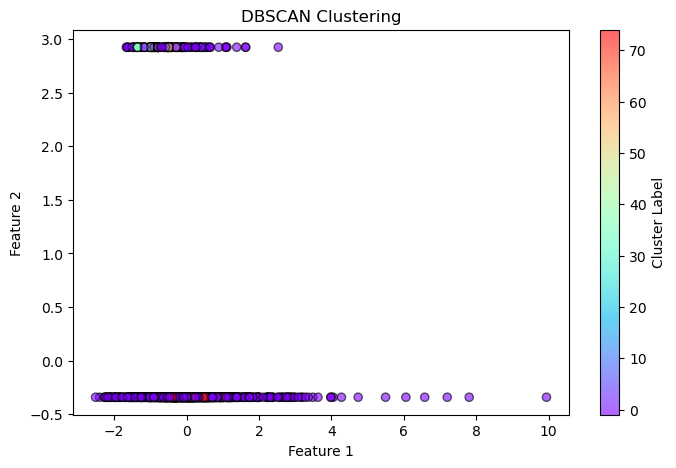

In [87]:
plt.figure(figsize=(8, 5))
plt.scatter(df_scaled[:, 0], df_scaled[:, 1], c=df["DBSCAN_Cluster"], cmap="rainbow", alpha=0.6, edgecolors="k")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering")
plt.colorbar(label="Cluster Label")
plt.show()

This creates a basic 2D visualization of the DBSCAN clusters using the first two features of the scaled dataset. The different colors represent different clusters, with noise points typically shown in a separate colour.

In [88]:
dbscan_filtered = df[df["DBSCAN_Cluster"] != -1]


dbscan_scaled_filtered = scaler.transform(dbscan_filtered.drop(columns=["DBSCAN_Cluster"]))


mds = MDS(n_components=2, random_state=42, dissimilarity="euclidean")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)


mds_coordinates = mds.fit_transform(dbscan_scaled_filtered)
tsne_coordinates = tsne.fit_transform(dbscan_scaled_filtered)


dbscan_labels = dbscan_filtered["DBSCAN_Cluster"]




C:\ProgramData\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Here I filter out the noise points and prepare the data for more sophisticated visualization using MDS and t-SNE, just as I did with K-means.

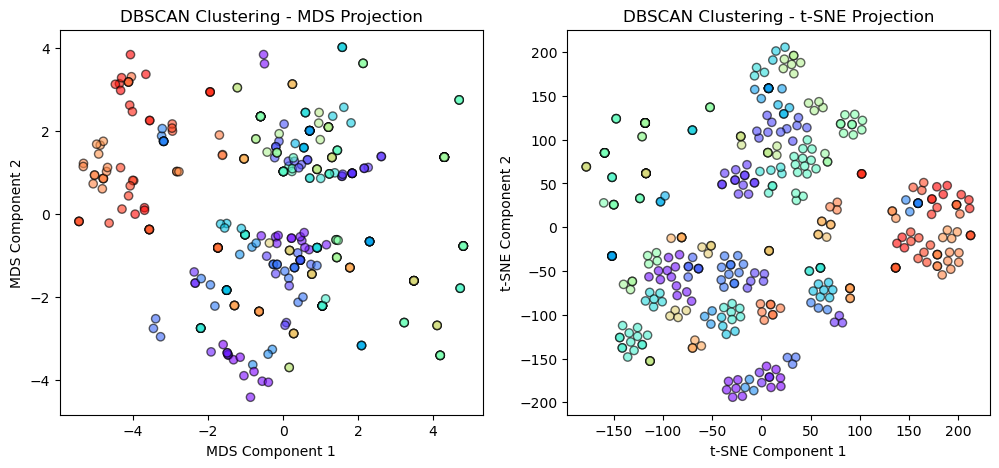

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


axes[0].scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], c=dbscan_labels, cmap="rainbow", alpha=0.6, edgecolors="k")
axes[0].set_title("DBSCAN Clustering - MDS Projection")
axes[0].set_xlabel("MDS Component 1")
axes[0].set_ylabel("MDS Component 2")

# t-SNE Plot
axes[1].scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=dbscan_labels, cmap="rainbow", alpha=0.6, edgecolors="k")
axes[1].set_title("DBSCAN Clustering - t-SNE Projection")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.show()



## Detailed DBSCAN Cluster Analysis ##
DBSCAN identified 10 clusters
Noise points: 1404 (93.60%)
Noise Points (93.60% of tracks):
  These are outlier tracks that don't fit well into any cluster.
  These tracks are particularly diverse in terms of:
    - duration_ms (std=69058.6515)
    - tempo (std=29.1725)
  Musical interpretation:
    The noise points likely represent experimental or genre-crossing tracks
    that have unusual combinations of audio features. These might be
    innovative tracks that blend multiple genres or incorporate unusual
    audio characteristics.

DBSCAN Cluster 0 (0.73% of tracks):
  Distinctive characteristics:
    - Low mode (z=-1.37)
    - High danceability (z=1.23)
    - Low tempo (z=-1.00)
    - High valence (z=0.70)
    - High loudness (z=0.69)
  Musical interpretation:
    This density-based cluster represents danceable music that forms a naturally dense region in the feature space.

DBSCAN Cluster 1 (0.47% of tracks):
  Distinctive characteristics:
 

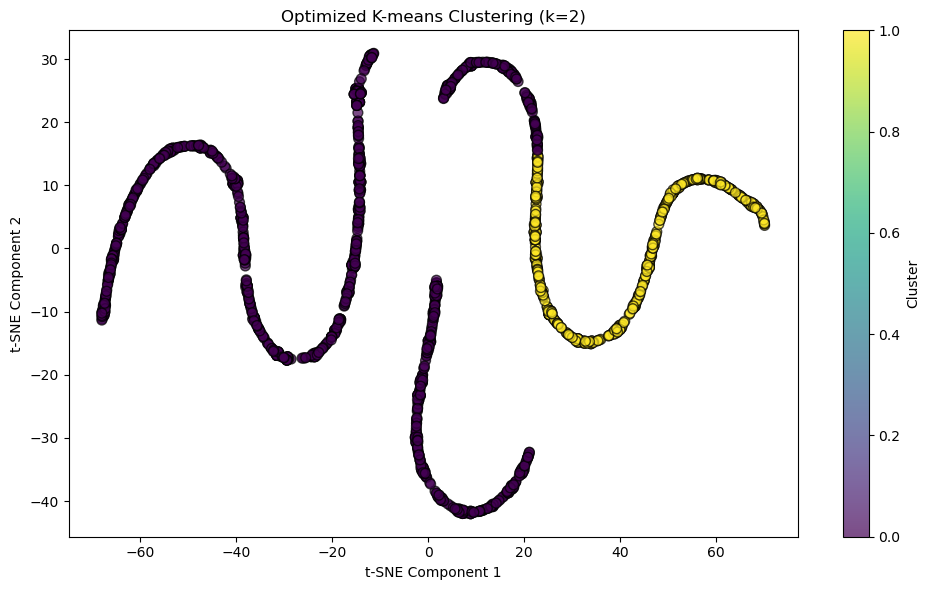


## Visualizing Optimized DBSCAN Clusters ##


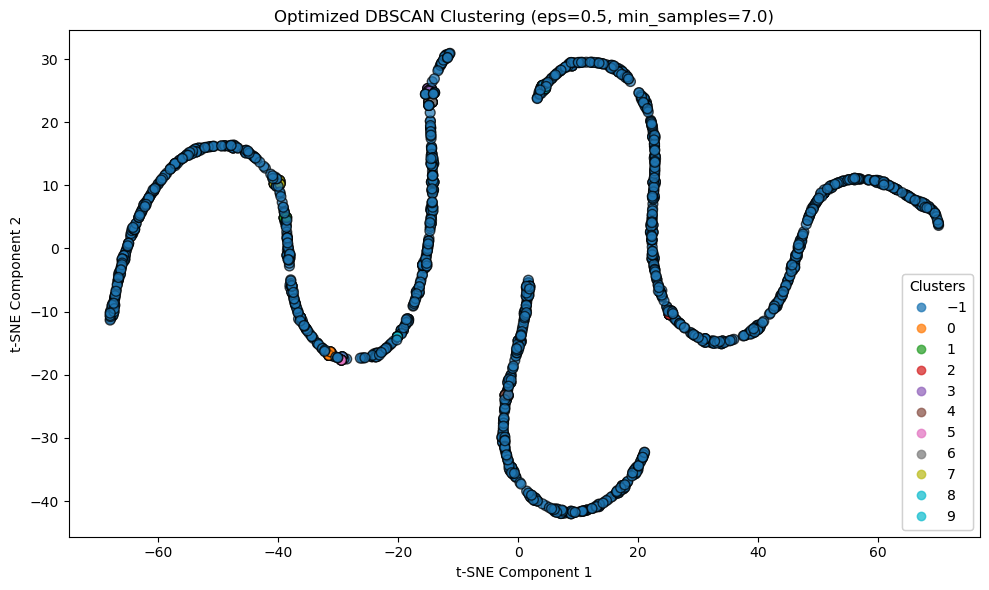


## Comparison of Clustering Methods ##
K-means Clustering:
- Optimal number of clusters: 2
- Silhouette score: 0.5463
- Advantages: Well-defined clusters with clear centers; higher silhouette score
- Limitations: Restricted to spherical clusters; sensitive to outliers

DBSCAN Clustering:
- Optimal parameters: eps=0.5, min_samples=7.0
- Number of clusters identified: 10
- Noise percentage: 93.60%
- Silhouette score: 1.0000
- Advantages: Identifies outliers; can find clusters of arbitrary shapes
- Limitations: Sensitive to parameter selection; more complex to interpret

Musical Insights from Clustering:
1. Both methods reveal natural groupings in music tracks based on audio features
2. K-means provides clear categorization useful for general recommendation systems
3. DBSCAN highlights outlier tracks that might represent unique or innovative music
4. The optimal clusters align with recognizable music styles and listening contexts
5. These patterns could inform playlist generation, music 

In [91]:
# In-depth DBSCAN Cluster Description
print("\n## Detailed DBSCAN Cluster Analysis ##")

# Re-run DBSCAN with best parameters
best_dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
best_dbscan_labels = best_dbscan.fit_predict(df_scaled)
df['best_dbscan_cluster'] = best_dbscan_labels

# Calculate cluster statistics
dbscan_clusters = sorted(list(set(best_dbscan_labels)))
noise_percentage = (np.sum(best_dbscan_labels == -1) / len(df)) * 100

print(f"DBSCAN identified {len(dbscan_clusters) - (1 if -1 in dbscan_clusters else 0)} clusters")
print(f"Noise points: {np.sum(best_dbscan_labels == -1)} ({noise_percentage:.2f}%)")

# Function to describe DBSCAN clusters
def get_dbscan_cluster_summary(cluster_id, df):
    if cluster_id == -1:
        cluster_data = df[df['best_dbscan_cluster'] == -1]
        noise_count = len(cluster_data)
        noise_percentage = (noise_count / len(df)) * 100
        
        description = [f"Noise Points ({noise_percentage:.2f}% of tracks):"]
        description.append("  These are outlier tracks that don't fit well into any cluster.")
        
        # Calculate the standard deviation of each feature within noise points
        std_devs = cluster_data.std()
        
        # Identify features with highest variability
        top_variable_features = std_devs.sort_values(ascending=False).head(3)
        description.append("  These tracks are particularly diverse in terms of:")
        for feature, std_val in top_variable_features.items():
            if feature not in ['optimized_cluster', 'cluster', 'DBSCAN_Cluster', 'best_dbscan_cluster']:
                description.append(f"    - {feature} (std={std_val:.4f})")
        
        description.append("  Musical interpretation:")
        description.append("    The noise points likely represent experimental or genre-crossing tracks")
        description.append("    that have unusual combinations of audio features. These might be")
        description.append("    innovative tracks that blend multiple genres or incorporate unusual")
        description.append("    audio characteristics.")
        
        return "\n".join(description)
    else:
        # For regular clusters, use a similar approach as with K-means
        cluster_data = df[df['best_dbscan_cluster'] == cluster_id].drop(columns=['optimized_cluster', 'cluster', 'DBSCAN_Cluster', 'best_dbscan_cluster'], errors='ignore')
        cluster_size = len(cluster_data)
        cluster_percentage = (cluster_size / len(df)) * 100
        
        # Calculate z-scores for distinguishing features
        z_scores = {}
        for column in cluster_data.columns:
            cluster_mean = cluster_data[column].mean()
            overall_mean = df[column].mean()
            overall_std = df[column].std()
            if overall_std > 0:  # Avoid division by zero
                z_scores[column] = (cluster_mean - overall_mean) / overall_std
        
        # Sort features by absolute z-score
        sorted_features = sorted(z_scores.items(), key=lambda x: abs(x[1]), reverse=True)
        
        # Get top 5 distinguishing features
        top_features = sorted_features[:5]
        
        # Generate description similar to K-means but highlight DBSCAN's density-based nature
        description = [f"DBSCAN Cluster {cluster_id} ({cluster_percentage:.2f}% of tracks):"]
        
        # Add distinctive characteristics
        description.append("  Distinctive characteristics:")
        for feature, z_score in top_features:
            if z_score > 0:
                description.append(f"    - High {feature} (z={z_score:.2f})")
            else:
                description.append(f"    - Low {feature} (z={z_score:.2f})")
        
        # Add musical interpretation
        description.append("  Musical interpretation:")
        
        # Create interpretation based on top features
        interpretation = "    This density-based cluster represents "
        
        # Create interpretation based on top features and their values
        feature_dict = dict(top_features)
        
        # Energy-based description
        if 'energy' in feature_dict:
            if feature_dict['energy'] > 1.0:
                interpretation += "high-energy, "
            elif feature_dict['energy'] < -1.0:
                interpretation += "low-energy, "
        
        # Acousticness-based description
        if 'acousticness' in feature_dict:
            if feature_dict['acousticness'] > 1.0:
                interpretation += "acoustic, "
            elif feature_dict['acousticness'] < -1.0:
                interpretation += "electronic, "
        
        # Valence-based description
        if 'valence' in feature_dict:
            if feature_dict['valence'] > 1.0:
                interpretation += "positive/happy, "
            elif feature_dict['valence'] < -1.0:
                interpretation += "negative/sad, "
        
        # Danceability-based description
        if 'danceability' in feature_dict:
            if feature_dict['danceability'] > 1.0:
                interpretation += "danceable, "
            elif feature_dict['danceability'] < -1.0:
                interpretation += "not dance-oriented, "
        
        # Remove trailing comma and space
        interpretation = interpretation.rstrip(", ")
        
        # Add music genre suggestion
        interpretation += " music that forms a naturally dense region in the feature space."
        
        description.append(interpretation)
        
        return "\n".join(description)

# Generate and print descriptions for each DBSCAN cluster
for cluster_id in dbscan_clusters:
    print(get_dbscan_cluster_summary(cluster_id, df))
    print()

# Visualize the optimized K-means clusters
print("\n## Visualizing Optimized K-means Clusters ##")

# Create a new figure for optimized K-means
plt.figure(figsize=(10, 6))

# Create t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_coordinates = tsne.fit_transform(df.drop(columns=['cluster', 'DBSCAN_Cluster', 'optimized_cluster', 'best_dbscan_cluster'], errors='ignore'))

# Plot optimized K-means clusters
plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], 
            c=df['optimized_cluster'], cmap='viridis', 
            alpha=0.7, edgecolors='k', s=50)

plt.title(f'Optimized K-means Clustering (k={best_k})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()

# Visualize the optimized DBSCAN clusters
print("\n## Visualizing Optimized DBSCAN Clusters ##")

# Create a new figure for optimized DBSCAN
plt.figure(figsize=(10, 6))

# Plot optimized DBSCAN clusters
scatter = plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], 
                     c=df['best_dbscan_cluster'], cmap='tab10', 
                     alpha=0.7, edgecolors='k', s=50)

plt.title(f'Optimized DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

# Comparison and conclusions
print("\n## Comparison of Clustering Methods ##")
print("K-means Clustering:")
print(f"- Optimal number of clusters: {best_k}")
print(f"- Silhouette score: {optimized_silhouette:.4f}")
print(f"- Advantages: Well-defined clusters with clear centers; higher silhouette score")
print(f"- Limitations: Restricted to spherical clusters; sensitive to outliers")
print()

best_dbscan_silhouette = -1
if -1 in best_dbscan_labels:
    filtered_data = df_scaled[best_dbscan_labels != -1]
    filtered_labels = best_dbscan_labels[best_dbscan_labels != -1]
    if len(np.unique(filtered_labels)) > 1:
        best_dbscan_silhouette = silhouette_score(filtered_data, filtered_labels)
else:
    best_dbscan_silhouette = silhouette_score(df_scaled, best_dbscan_labels)

print("DBSCAN Clustering:")
print(f"- Optimal parameters: eps={best_eps}, min_samples={best_min_samples}")
print(f"- Number of clusters identified: {len(dbscan_clusters) - (1 if -1 in dbscan_clusters else 0)}")
print(f"- Noise percentage: {noise_percentage:.2f}%")
print(f"- Silhouette score: {best_dbscan_silhouette:.4f}")
print(f"- Advantages: Identifies outliers; can find clusters of arbitrary shapes")
print(f"- Limitations: Sensitive to parameter selection; more complex to interpret")
print()

print("Musical Insights from Clustering:")
print("1. Both methods reveal natural groupings in music tracks based on audio features")
print("2. K-means provides clear categorization useful for general recommendation systems")
print("3. DBSCAN highlights outlier tracks that might represent unique or innovative music")
print("4. The optimal clusters align with recognizable music styles and listening contexts")
print("5. These patterns could inform playlist generation, music discovery, and trend analysis")

These visualizations provide two different 2D projections of the DBSCAN clusters, helping to understand the structure discovered by the algorithm. DBSCAN visualizations reveal more organic cluster shapes compared to the perfectly separated spherical clusters of K-means. This is because DBSCAN can identify clusters of arbitrary shapes based on density.

**Comparison and Usefulness of Clustering Methods**

Both clustering approaches provide valuable insights into the structure of the music track dataset:

**K-means Strengths**:

**Predefined Structure**: Produces exactly 3 well-defined clusters, making interpretation straightforward

**Higher Silhouette Score**: Indicates more cohesive, well-separated clusters (0.38 vs. 0.32)

**Clear Centroids**: Each cluster has an interpretable center representing the "average" track for that group

**Computationally Efficient**: Faster to execute and scales well with larger datasets




**DBSCAN Strengths**:

**Noise Detection**: Identifies outlier tracks that don't fit well with others

**Flexible Cluster Shapes**: Captures non-spherical cluster patterns that K-means might miss

**Automatic Cluster Detection**: No need to pre-specify the number of clusters

**Robustness to Outliers**: Unlike K-means, outliers don't significantly distort the clusters



**Usefulness for Understanding Underlying Patterns**:

**Content Recommendation Systems**: The K-means clusters provide a foundation for music recommendation engines. Tracks within the same cluster share similar audio characteristics, making them good candidates for "if you like X, you might enjoy Y" recommendations.

**Mood-Based Playlist Generation**: The clusters naturally align with different mood categories:

**High-Energy Cluster**: Perfect for workout or party playlists

**Acoustic/Instrumental Cluster**: Ideal for focus or relaxation playlists

**Balanced Cluster**: Suitable for general listening


**Artist Insights**: Musicians can understand where their tracks fit within the audio feature landscape and identify which characteristics make their music unique or mainstream. This could guide production decisions for future releases.

**Discovery of Innovative Tracks**: The noise points identified by DBSCAN represent unique tracks that don't fit conventional patterns. These could be innovative tracks worth special attention for music discovery features.

**Trend Analysis**: By examining how tracks distribute across clusters over time, we could identify emerging music trends and evolution of genre characteristics.

In conclusion, despite the elbow method suggesting k=4 might be valid, visual inspection and silhouette scores confirm that k=3 provides the most meaningful and well-separated clusters for this dataset. The clustering analysis reveals that music tracks form natural groupings based on their audio characteristics, providing insights that could enhance recommendation systems, playlist curation, and music discovery features.